In [9]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix,recall_score,classification_report 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree, to_graphviz
from sklearn.naive_bayes import GaussianNB

(191497, 122)


A75F                                                        2
Unnamed: 0                                             191497
coilno                                                 189966
fmtargetthickwhqh                                         274
fmtargetwidthwhqh                                         766
targetft                                                   19
targetct                                                   24
ds_yield_stress                                            13
ds_tensile_strength                                        23
ds_C                                                       89
ds_Si                                                       8
ds_Mn                                                     114
ds_P                                                       26
ds_S                                                       19
ds_Cu                                                      10
ds_Ni                                                       8
ds_Cr   

(191497, 121)
(191497, 1)
(14803, 1)
(176694, 1)
樣本個數：191497; 正樣本佔92.27%; 負樣本占7.73%
特徵維度： 121
0.5
Total number of transactions in resampled data:  29606


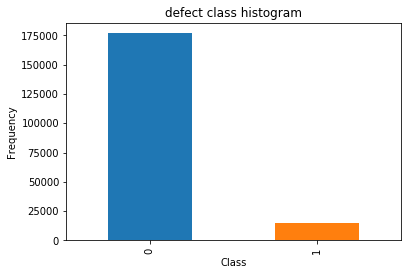

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data1=pd.read_csv('A75F_no_continuous.csv')
data1.head()

data1.shape
data1.dtypes

data = data1.select_dtypes(include=[np.number])

data.isnull().sum()

A75Fdropna = data.dropna(axis=1) #將有缺失值的列刪除
print(A75Fdropna.shape)

a75f = A75Fdropna['A75F']
A75Fdropna.drop(labels=['A75F'], axis=1,inplace = True)
A75Fdropna.insert(0, 'A75F', a75f)



A75Fdropna.head()

df_unq = A75Fdropna.apply(lambda x: x.nunique())
display(df_unq)

# A75Fdropna.drop(columns=['FM Deformation resistance\[1]','FM Deformation resistance\[2]',
#                          'FM Deformation resistance\[3]','FM Deformation resistance\[4]',
#                          'FM Deformation resistance\[5]','FM Deformation resistance\[6]',
#                          'FM Deformation resistance\[7]'], inplace=True)

# A75Fdropna.drop(columns=['ds_o2','ds_h2','ds_la','ds_ce'], inplace=True)

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
A75Fdropna.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in A75Fdropna.columns.values]


X=A75Fdropna.loc[:,A75Fdropna.columns!='A75F']
y=A75Fdropna.loc[:,A75Fdropna.columns=='A75F']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)


# trainA75F = A75Fdropna.drop(['A75F','coilno'],axis=1)
trainA75F = A75Fdropna.drop(['A75F'],axis=1)
print(trainA75F.shape)
defectA75F =  A75Fdropna.loc[:,['A75F']]
print(defectA75F.shape)
print(defectA75F[defectA75F.A75F==1].shape)
print(defectA75F[defectA75F.A75F==0].shape)
n_sample = defectA75F.shape[0]
n_pos_sample = defectA75F[defectA75F.A75F == 0].shape[0]
n_neg_sample = defectA75F[defectA75F.A75F == 1].shape[0]
print('樣本個數：{}; 正樣本佔{:.2%}; 負樣本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特徵維度：', trainA75F.shape[1])



count_classes=pd.value_counts(data["A75F"],sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("defect class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# from sklearn.preprocessing import StandardScaler

# data['normSGC']=StandardScaler().fit_transform(data['SGC'].values.reshape(-1,1))

# data=data.drop(['SGC'],axis=1)
# print(data.head())

#特征数据
X=A75Fdropna.loc[:,A75Fdropna.columns!='A75F']

y=A75Fdropna.loc[:,A75Fdropna.columns=='A75F']
# print(y)

number_records_fraud = len(A75Fdropna[A75Fdropna.A75F==1]) 
#print (number_records_fraud)  
#print (data[data.Class == 1].index)
fraud_indices = np.array(A75Fdropna[A75Fdropna.A75F == 1].index)   
#print (fraud_indices)
normal_indices = A75Fdropna[A75Fdropna.A75F == 0].index   
random_normal_indices =np.random.choice(normal_indices,number_records_fraud,replace = False) 
random_normal_indices = np.array(random_normal_indices)
#print (len(random_normal_indices))  
 
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])  
#print (under_sample_indices)   
under_sample_data = A75Fdropna.iloc[under_sample_indices,:]  
X_undersample = under_sample_data.iloc[:,under_sample_data.columns != 'A75F']  #下采样后的训练集
y_undersample = under_sample_data.iloc[:,under_sample_data.columns == 'A75F']   #下采样后的标签
 
print (len(under_sample_data[under_sample_data.A75F==1])/len(under_sample_data)) # 正负样本的比例都是 0.5
# print(X_undersample)
print("Total number of transactions in resampled data: ", len(under_sample_data))

In [3]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_undersample, y_undersample, test_size=0.2, random_state=42)


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
    
from xgboost import XGBClassifier, plot_importance, plot_tree, to_graphviz

XGBC_u = XGBClassifier()
XGBC_u.fit(X_train_u,y_train_u)
predicted_XGBC_u = XGBC_u.predict(X_test_u) # 透過分類器產生預測下採樣结果
print("XGBOOST")
print("Test set accuracy score(under sample): {:.5f}".format(accuracy_score(predicted_XGBC_u, y_test_u,)))
cnf_matrix = confusion_matrix(y_test_u,predicted_XGBC_u) #confusion_matrix函数的两个参数：测试集上y的真实分类，y的预测值
np.set_printoptions(precision=2)
print("XGBOOST")
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])) #召回率：TP/(TP+FN)

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()




XGBC_u = XGBClassifier()
XGBC_u.fit(X_train_u,y_train_u)

predicted_XGBC_u = XGBC_u.predict(X_test) # 透過分類器產生預測下採樣结果
print("XGBOOST")
print("Test set accuracy score(normal sample): {:.5f}".format(accuracy_score(predicted_XGBC_u, y_test,)))


cnf_matrix = confusion_matrix(y_test,predicted_XGBC_u) #confusion_matrix函数的两个参数：测试集上y的真实分类，y的预测值
np.set_printoptions(precision=2)
print("XGBOOST") 
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])) #召回率：TP/(TP+FN)

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()





DTC_u = RandomForestClassifier(n_estimators=1000,  max_depth=1000,  
min_samples_split=4, min_samples_leaf=2)
DTC_u.fit(X_train_u,y_train_u)

predicted_DTC_u = DTC_u.predict(X_test_u) # 透過分類器產生預測下採樣结果
print("RandomForest")
print("Test set accuracy score(under sample): {:.5f}".format(accuracy_score(predicted_DTC_u, y_test_u,)))


cnf_matrix = confusion_matrix(y_test_u,predicted_DTC_u) #confusion_matrix函数的两个参数：测试集上y的真实分类，y的预测值
np.set_printoptions(precision=2)
print("RandomForest") 
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])) #召回率：TP/(TP+FN)

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()






DTC_u = RandomForestClassifier(n_estimators=1000,  max_depth=1000,  
min_samples_split=4, min_samples_leaf=2)
DTC_u.fit(X_train_u,y_train_u)

predicted_DTC_u = DTC_u.predict(X_test) # 透過分類器產生預測下採樣结果
print("RandomForest") 
print("Test set accuracy score(normal sample): {:.5f}".format(accuracy_score(predicted_DTC_u, y_test,)))


cnf_matrix = confusion_matrix(y_test,predicted_DTC_u) #confusion_matrix函数的两个参数：测试集上y的真实分类，y的预测值
np.set_printoptions(precision=2)
print("RandomForest")  
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])) #召回率：TP/(TP+FN)

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

NameError: name 'X_undersample' is not defined

Text(0,0.5,'Frequency')

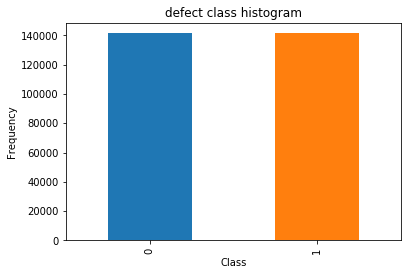

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

data2=pd.read_csv('A75F_no_continuous.csv')




data2 = data2.select_dtypes(include=[np.number])

A75Fdropna = data2.dropna(axis=1) #將有缺失值的列刪除

a75f = A75Fdropna['A75F']
A75Fdropna.drop(labels=['A75F'], axis=1,inplace = True)
A75Fdropna.insert(0, 'A75F', a75f)

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
# credit_cards.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in credit_cards.columns.values]
A75Fdropna.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in A75Fdropna.columns.values]
# credit_cards["sgf"]=credit_cards["sgf"].fillna(credit_cards["sgf"].median())
# # data["lengthpositione"]=data["lengthpositione"].fillna(data["lengthpositione"].median())
# credit_cards["LP1 MAN SUCC OFFSET from HMI G300"]=credit_cards["LP1 MAN SUCC OFFSET from HMI G300"].fillna(credit_cards["LP1 MAN SUCC OFFSET from HMI G300"].median())
# credit_cards["LP1 Touch Angle"]=credit_cards["LP1 Touch Angle"].fillna(credit_cards["LP1 Touch Angle"].median())
# credit_cards["LP2 MAN SUCC OFFSET from HMI G300"]=credit_cards["LP2 MAN SUCC OFFSET from HMI G300"].fillna(credit_cards["LP2 MAN SUCC OFFSET from HMI G300"].median())
# credit_cards["LP2 Touch Angle"]=credit_cards["LP2 Touch Angle"].fillna(credit_cards["LP2 Touch Angle"].median())
# credit_cards["LP3 MAN SUCC OFFSET from HMI G300"]=credit_cards["LP3 MAN SUCC OFFSET from HMI G300"].fillna(credit_cards["LP3 MAN SUCC OFFSET from HMI G300"].median())
# credit_cards["LP3 Touch Angle"]=credit_cards["LP3 Touch Angle"].fillna(credit_cards["LP3 Touch Angle"].median())
# credit_cards["LP4 MAN SUCC OFFSET from HMI G300"]=credit_cards["LP4 MAN SUCC OFFSET from HMI G300"].fillna(credit_cards["LP4 MAN SUCC OFFSET from HMI G300"].median())
# credit_cards["LP4 Touch Angle"]=credit_cards["LP4 Touch Angle"].fillna(credit_cards["LP4 Touch Angle"].median())
# credit_cards["LP5 MAN SUCC OFFSET from HMI G300"]=credit_cards["LP5 MAN SUCC OFFSET from HMI G300"].fillna(credit_cards["LP5 MAN SUCC OFFSET from HMI G300"].median())
# credit_cards["LP5 Touch Angle"]=credit_cards["LP5 Touch Angle"].fillna(credit_cards["LP5 Touch Angle"].median())
# credit_cards["LP6 MAN SUCC OFFSET from HMI G300"]=credit_cards["LP6 MAN SUCC OFFSET from HMI G300"].fillna(credit_cards["LP6 MAN SUCC OFFSET from HMI G300"].median())
# credit_cards["LP6 Touch Angle"]=credit_cards["LP6 Touch Angle"].fillna(credit_cards["LP6 Touch Angle"].median())


# credit_cards.isnull().sum()

X=A75Fdropna.loc[:,A75Fdropna.columns!='A75F']
y=A75Fdropna.loc[:,A75Fdropna.columns=='A75F']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)




                                                                        

#初始化SMOTE 模型
oversampler=SMOTE(random_state=0)
#使用SMOTE模型，创造新的数据集
# os_features,os_labels=oversampler.fit_sample(features_train,labels_train)
os_features,os_labels=oversampler.fit_sample(X_train,y_train)
#切分新生成的数据集
# os_features_train, os_features_test, os_labels_train, os_labels_test = train_test_split(os_features, 
#                                                                             os_labels, 
#                                                                             test_size=0.3,random_state=0 )



os_count_classes = pd.value_counts(os_labels, sort = True).sort_index()
os_count_classes.plot(kind = 'bar')
plt.title("defect class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

DecisionTree
Test set accuracy score(over sample): 0.91303
DecisionTree
Recall metric in the testing dataset:  0.29803122878479293


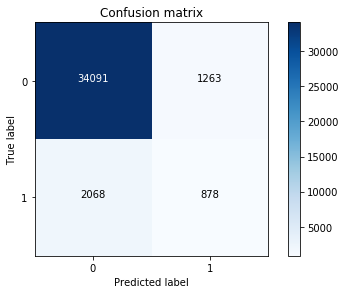

In [10]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)

XGBC_s = XGBClassifier()
XGBC_s.fit(os_features_train,os_labels_train)


predicted_XGBC_s = XGBC_s.predict(os_features_test) # 透過分類器產生預測上採樣结果
print("XGBOOST")
print("Test set accuracy score(over sample): {:.5f}".format(accuracy_score(predicted_XGBC_s, os_labels_test,)))


# Compute confusion matrix
cnf_matrix = confusion_matrix(os_labels_test,predicted_XGBC_s)
np.set_printoptions(precision=2)
print("XGBOOST")
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()












DTC=DecisionTreeClassifier()
DTC.fit(os_features_train,os_labels_train)
predicted_DTC = DTC.predict(os_features_test) # 透過分類器產生預測上採樣结果
print("DecisionTree")
print("Test set accuracy score(over sample): {:.5f}".format(accuracy_score(predicted_DTC, os_labels_test,)))


# Compute confusion matrix
cnf_matrix = confusion_matrix(os_labels_test,predicted_DTC)
np.set_printoptions(precision=2)
print("DecisionTree")
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()



lr=KNeighborsClassifier()
lr.fit(os_features_train,os_labels_train)
predicted_lr = lr.predict(os_features_test) # 透過分類器產生預測上採樣结果
print("KNeighbors")
print("Test set accuracy score(over sample): {:.5f}".format(accuracy_score(predicted_lr, os_labels_test,)))


# Compute confusion matrix
cnf_matrix = confusion_matrix(os_labels_test,predicted_lr)
np.set_printoptions(precision=2)
print("KNeighbors")
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()





clf=GaussianNB()
clf.fit(os_features_train,os_labels_train)
predicted_clf = clf.predict(os_features_test) # 透過分類器產生預測上採樣结果
print("GaussianNB")
print("Test set accuracy score(over sample): {:.5f}".format(accuracy_score(predicted_clf, os_labels_test,)))


# Compute confusion matrix
cnf_matrix = confusion_matrix(os_labels_test,predicted_clf)
np.set_printoptions(precision=2)
print("GaussianNB")
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()





clfR=RandomForestClassifier(n_estimators=1000,  max_depth=1000,  
min_samples_split=4, min_samples_leaf=2)
clfR.fit(os_features_train,os_labels_train)
predicted_clfR = clfR.predict(os_features_test) # 透過分類器產生預測上採樣结果
print("GaussianNB")
print("Test set accuracy score(over sample): {:.5f}".format(accuracy_score(predicted_clfR, os_labels_test,)))


# Compute confusion matrix
cnf_matrix = confusion_matrix(os_labels_test,predicted_clfR)
np.set_printoptions(precision=2)
print("GaussianNB")
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()




